In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle


##Parsing the JSON file for annotations.

<br/>

### JSON File Structure

The annotation file is of COCO format and have the following structure
- **images**
  - **id**: Id of the image
  - **width**: Image width
  - **height**: Image height
  - **filename**: Image file name
  - **license**: License id of the image
  - **date_captured**: Date of capture of the image
- **annotations**
  - **id**: Annotation id
  - **image_id**: Id of the image the annotation is associated with
  - **category_id**: Id of the class the annotation belongs to
  - **segmentation**: (x, y) coordinates of the four corners of the bounding box
  - **area**: Bounding box area
  - **bbox**: (x, y) coordinate of the top-left corner and width and height of the bounding box
  - **iscrowd**: If the image has a crowd of objects denoted by this annotation


In [2]:
def load_json(path):
    with open(path) as f:
        annotations = eval(f.read())
    return annotations

In [3]:

def get_data_points(annotations):
    data_points = []
    for annotation in annotations['annotations']:
        bounding_box = annotation['bbox']
        img = annotations['images'][int(annotation['image_id'])-1]

        data_points.append((
            bounding_box[2] / img['width'],
            bounding_box[3] / img['height']
        ))
    return np.array(data_points)

In [4]:
annotations = load_json('dataset.json')
data_points = get_data_points(annotations)

Text(0, 0.5, 'height')

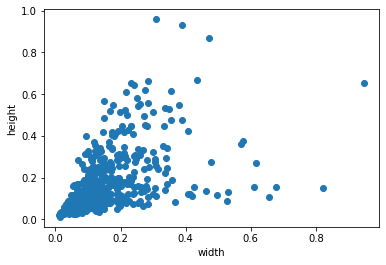

In [5]:
plt.scatter(data_points[:, 0], data_points[:, 1])
plt.xlabel('width')
plt.ylabel('height')

Text(0, 0.5, 'log(height)')

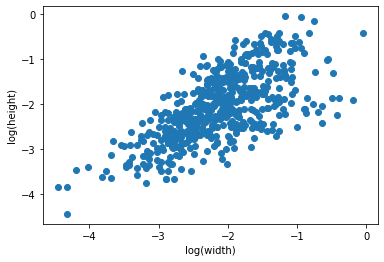

In [6]:
plt.scatter(np.log(data_points[:, 0]), np.log(data_points[:, 1]))
plt.xlabel('log(width)')
plt.ylabel('log(height)')

In [7]:

class KMeans:

    def __init__(self, num_clusters, points, iterations):

        self.num_clusters = num_clusters
        self.points = points
        self.iterations = iterations

        self.centroids = self.initialize_centroids()
        self.closest = None
        self.mean_iou = None

        self.find_clusters()
        self.iou()

    def initialize_centroids(self):

        centroids = self.points.copy()
        np.random.shuffle(centroids)
        return centroids[:self.num_clusters]

    def closest_centroid(self):

        distances = np.sqrt(
            ((self.points - self.centroids[:, np.newaxis]) ** 2).sum(axis=2)
        )
        self.closest = np.argmin(distances, axis=0)

    def move_centroids(self):

        self.centroids =  np.array([
            self.points[self.closest == k].mean(axis=0)
            for k in range(self.centroids.shape[0])
        ])
    
    def find_clusters(self):

        for _ in range(self.iterations):
            self.closest_centroid()
            self.move_centroids()
    
    def iou(self):

        closest_centroids = self.centroids[self.closest]
        width = np.minimum(
            closest_centroids[:, 0], self.points[:, 0]
        )
        height = np.minimum(
            closest_centroids[:, 1], self.points[:, 1]
        )

        intersection = width * height
        points_area = self.points[:, 0] * self.points[:, 1]
        cluster_area = closest_centroids[:, 0] * closest_centroids[:, 1]

        self.mean_iou = np.mean(
            intersection / (points_area + cluster_area - intersection)
        )

In [8]:
iou_list = []
kmeans_model = {}

num_clusters_start = 1
num_clusters_end = 16

iterations = 300

for k in range(num_clusters_start, num_clusters_end + 1):
    kmeans_model[k + 1] = KMeans(k + 1, data_points, iterations)
    iou_list.append(kmeans_model[k + 1].mean_iou)

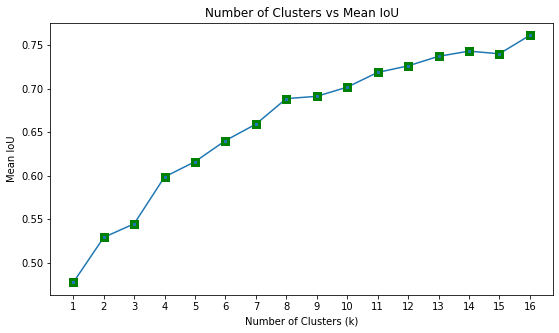

In [9]:
fig = plt.figure(figsize=(9, 5))

_ = plt.plot(iou_list, '-s', markeredgecolor='green', markeredgewidth=3)

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Mean IoU')

plt.xticks(np.arange(len(iou_list)), np.arange(1, len(iou_list)+1))
plt.title('Number of Clusters vs Mean IoU')

fig.savefig('kmeans_iou.png')

In [10]:
def plot_clusters(kmeans):
    num_clusters = kmeans.num_clusters

    # Plot points for each cluster
    for cluster_id in range(num_clusters):
        points = kmeans.points[kmeans.closest == cluster_id]
        plt.scatter(points[:, 0], points[:, 1])
    
    # Plot centroids
    plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='black', s=90, marker='x')
    plt.xlabel('width')
    plt.ylabel('height')
    plt.title(f'Cluster Plot for k = {num_clusters}')

    # Save figure
    plt.savefig(f'K{num_clusters}_cluster_plot.png')

Mean IOU: 0.54


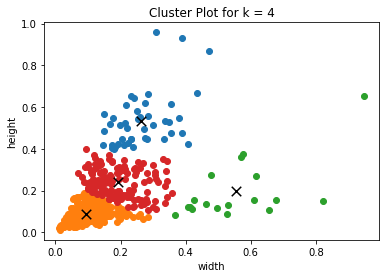

In [11]:
# Plotting for k = 4
print(f'Mean IOU: {kmeans_model[4].mean_iou:.2f}')
plot_clusters(kmeans_model[4])

Mean IOU: 0.64


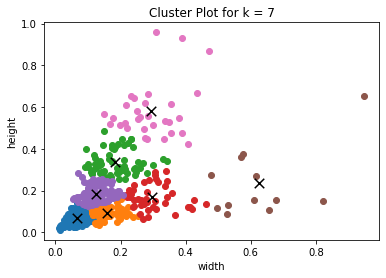

In [12]:
# Plotting for k = 7
print(f'Mean IOU: {kmeans_model[7].mean_iou:.2f}')
plot_clusters(kmeans_model[7])

In [13]:
def make_anchor_boxes(ax, clusters, edgecolor='b', alpha=1):

    xdata = np.array([0.5]*len(clusters))
    ydata = np.array([0.5]*len(clusters))

    xerror = np.array([list(np.exp(clusters[:, 0])/2)]*2)
    yerror = np.array([list(np.exp(clusters[:, 1])/2)]*2)

    # Creating the list for all the error patches
    errorboxes = []

    for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T):
        rect = Rectangle((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
        errorboxes.append(rect)

    pc = PatchCollection(
        errorboxes, facecolor='None', alpha=alpha, edgecolor=edgecolor
    )

    # Adding collection to axes
    ax.add_collection(pc)

    # Plotting errorbars
    errorbars = ax.errorbar(
        xdata, ydata, xerr=xerror, yerr=yerror, fmt='None', ecolor='None'
    )

    return errorbars

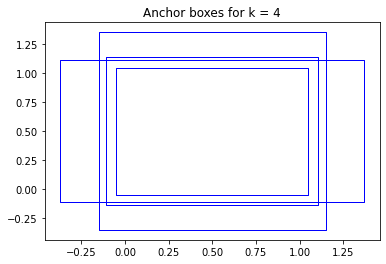

In [14]:
# Creating figure and axes
fig, ax = plt.subplots(1)

# Creating error boxes
_ = make_anchor_boxes(ax, kmeans_model[4].centroids)

plt.title('Anchor boxes for k = 4')
plt.show()
fig.savefig('K4_anchor_box.png')

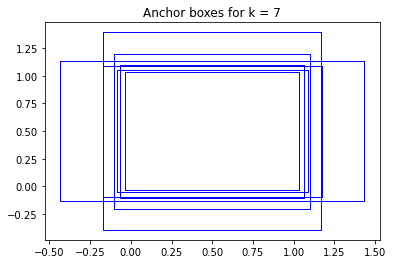

In [15]:
# Creating figure and axes
fig, ax = plt.subplots(1)

# Creating error boxes
_ = make_anchor_boxes(ax, kmeans_model[7].centroids)

plt.title('Anchor boxes for k = 7')
plt.show()
fig.savefig('K7_anchor_box.png')